In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
from datetime import datetime
import pandas as pd
from tqdm.autonotebook import tqdm
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.networks.gaia import GAIA
from avgn.networks.test_datasets import load_fashion_MNIST
from avgn.networks.sample_networks import fc_net, conv_net

In [5]:
epochs = 100
latent_dim = 512
batch_size = 64
dims = (28 , 28, 1)

In [6]:
from tensorflow.keras.layers import (
    RepeatVector,
    Dense,
    TimeDistributed,
    Conv1D,
    Conv2D,
    Reshape,
    Bidirectional,
    concatenate,
    Input,
    UpSampling2D,
    MaxPooling2D,
)  # , LSTM
from tensorflow.python.keras.layers.recurrent import UnifiedLSTM as LSTM
from tensorflow.python.keras.layers.recurrent import UnifiedGRU as GRU
from tensorflow.keras import Model

In [7]:
def unet_convblock_down(
    _input,
    channels=16,
    kernel=(3, 3),
    activation="relu",
    pool_size=(2, 2),
    kernel_initializer="he_normal",
):
    conv = Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(_input)
    conv = Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(conv)
    pool = MaxPooling2D(pool_size=pool_size)(conv)
    return conv, pool

In [8]:
def unet_convblock_up(
    last_conv,
    cross_conv,
    channels=16,
    kernel=(3, 3),
    activation="relu",
    pool_size=(2, 2),
    kernel_initializer="he_normal",
):
    
    up_conv = UpSampling2D(size=(2, 2))(last_conv)
    merge = concatenate([up_conv, cross_conv], axis = 3)
    conv = Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(merge)
    conv = Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(conv)
    return conv

In [9]:
def unet_mnist():
    inputs = Input(shape=(28, 28, 1))
    up_1, pool_1 = unet_convblock_down(inputs, channels=32)
    up_2, pool_2 = unet_convblock_down(pool_1, channels=64)
    conv_middle = Conv2D(
        128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
    )(pool_2)
    conv_middle = Conv2D(
        128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
    )(conv_middle)
    down_2 = unet_convblock_up(conv_middle, up_2, channels=64)
    down_1 = unet_convblock_up(down_2, up_1, channels=32)
    outputs = Conv2D(1, (1,1), activation="sigmoid")(down_1)
    return inputs, outputs

In [10]:
def plot_recon(example_data, nex = 3, zm = 2):
    z, xg, zi, xi, d_xi, d_x, d_xg = model.network_pass(example_data)
    fig, axs = plt.subplots(ncols=6, nrows = nex, figsize=(zm*6, zm*nex))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, xg, xi, d_xi, d_x, d_xg],
            ["data", "gen", "interp", "disc interp", "disc data", "disc gen"],
        )
    ):
        for ex in range(nex):
            axs[ex, axi].matshow(dat.numpy()[ex].squeeze(), cmap = plt.cm.Greys, vmin=0, vmax=1)
            axs[ex, axi].axis('off')
        axs[0, axi].set_title(lab)
        
    plt.show()

In [11]:
def plot_losses(losses):
    fig, axs = plt.subplots(ncols=4, figsize=(15,4))
    axs[0].semilogx(losses.D_prop.values, label = 'D_prop')
    axs[0].set_ylim([0,1])
    axs[1].loglog(losses.d_x_loss.values, label = 'd_x_loss')
    axs[2].loglog(losses.d_xg_loss.values, label='d_xg_loss')
    axs[3].loglog(losses.d_xi_loss.values, label='d_xi_loss')
    for ax in axs.flatten():
        ax.legend()
    plt.show()

In [12]:
def test_losses(model, test_dataset, batch_size=512, TEST_BUF=1000):
    niter = int((TEST_BUF / batch_size) - 2)
    test_loss = []
    tx = 0
    for test_x in tqdm(test_dataset, total=niter, leave=False):
        test_loss.append(model.compute_loss(test_x))
        tx += 1
        if tx > niter:
            break
    D_prop, d_x_loss, d_xg_loss, d_xi_loss = np.mean(
        [[i.numpy() for i in row] for row in test_loss], axis=0
    )
    return D_prop, d_x_loss, d_xg_loss, d_xi_loss

In [13]:
network_arch = conv_net(dims=dims, n_Z = latent_dim)

In [14]:
# get the datasets
TRAIN_BUF = 60000
train_dataset, test_dataset = load_fashion_MNIST(BATCH_SIZE=batch_size, TRAIN_BUF=TRAIN_BUF)

In [ ]:
from avgn.networks.gaia import GAIA

# prepare the optimizer
gen_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1 = 0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(1e-5)
# train the model
model = GAIA(
    enc = network_arch.encoder,
    dec = network_arch.decoder,
    unet_function = unet_mnist,
    dims = dims, 
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    lr = 1e-5, 
    alpha = 0.1,
    batch_size= batch_size,
    
)

In [ ]:
example_data = next(iter(train_dataset))
z = model.encode(example_data)
zi = model._interpolate_z(z)
d_x = model.discriminate(example_data)
#plot_recon(example_data)

In [ ]:
losses = pd.DataFrame(columns=['D_prop', 'd_x_loss', 'd_xg_loss', 'd_xi_loss'])

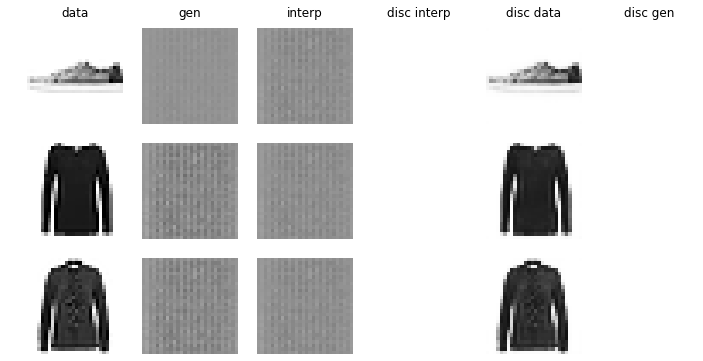

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  self.set_xlim(upper, lower, auto=None)


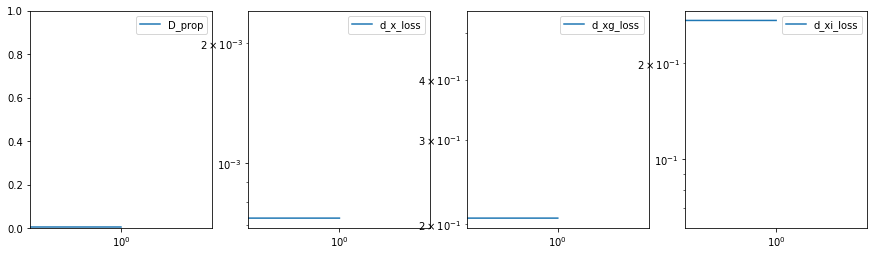

In [ ]:
for epoch in range(1000): 
    txi = 0
    for train_x in tqdm(train_dataset):
        if txi == int(TRAIN_BUF/batch_size)-1: continue
        try:
            model.train(train_x)
        except ValueError: 
            continue
        txi +=1
    display.clear_output(wait=False)
    plot_recon(example_data)
    losses.loc[len(losses)] = test_losses(model, test_dataset, batch_size=batch_size)
    plot_losses(losses)
    plt.show()

In [ ]:
plot_recon(example_data)

In [ ]:
### in a traditional GAN, the discriminator's job is to flip a switch. 

In [ ]:
## the discriminator should be perfectly good at reproducing inputs immediately
# the discriminators job is then to determine whether interpolated data is real